In [37]:
#Setting up and Reading the CRM data
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
# read csv file
df_Fact = pd.read_csv('//content//online_retail.csv')

In [38]:
# connecting data to database
conn = sqlite3.connect("online_retail")
cur = conn.cursor()

In [39]:
# loading CRM data into the RFMdb database
df_Fact.to_sql("online_retail", conn)

ValueError: ignored

In [40]:
# Checking if data was loaded in the database/RFMdb
df_Fact = pd.read_sql('SELECT * FROM online_retail', conn)

In [41]:
df_Fact

,index,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...,...
541905,541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,12.60
541906,541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,16.60
541907,541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France,16.60
541908,541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France,14.85


In [42]:
# checking for missing values
print("Missing values in dataset: ", df_Fact.isnull().sum().sum())

Missing values in dataset:  136534


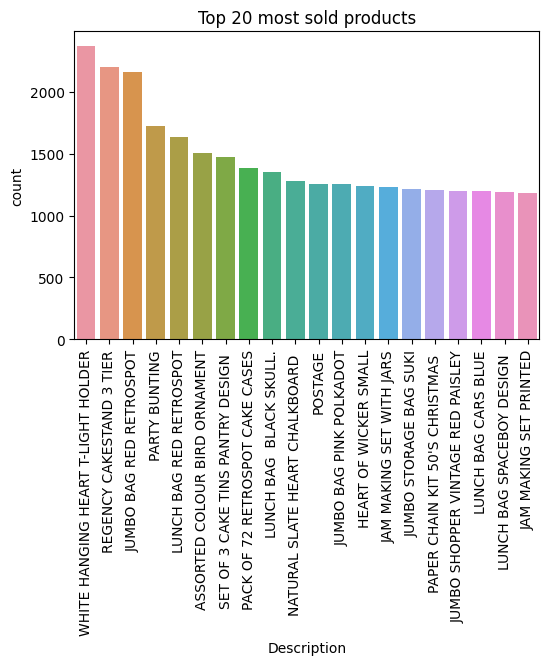

In [44]:
# visualizing the dataset by showing top 20 most sold products
plt.figure(figsize=(6,4))
sns.countplot(x='Description', data=df_Fact, order=df_Fact['Description'].value_counts().iloc[:20].index)
plt.xticks(rotation=90)
plt.title('Top 20 most sold products')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Data Cleaning

In [43]:
#Checking data type
df_Fact.columns = ['Index','Invoice','StockCode','Description','Quantity','InvoiceDate','Price','CustomerID', 'Country', 'Amount']
df_Fact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Index        541910 non-null  int64  
 1   Invoice      541910 non-null  object 
 2   StockCode    541910 non-null  object 
 3   Description  540456 non-null  object 
 4   Quantity     541910 non-null  int64  
 5   InvoiceDate  541910 non-null  object 
 6   Price        541910 non-null  float64
 7   CustomerID   406830 non-null  float64
 8   Country      541910 non-null  object 
 9   Amount       541910 non-null  float64
dtypes: float64(3), int64(2), object(5)
memory usage: 41.3+ MB


In [45]:
# loading the cleaned dataset to SQLITE
conn = sqlite3.connect('online_retail.db')
df_Fact.to_sql('online_retail', conn, if_exists='replace', index=False)

# verifying the data load
cursor = conn.cursor()
cursor.execute("SELECT COUNT(*) FROM online_retail")
print("Number of rows in SQLITE database: ", cursor.fetchone()[0])

Number of rows in SQLITE database:  541910


In [90]:
# Further data cleaning and data integration
online_retail1 = pd.read_sql('''
SELECT
    CustomerID,
    MAX(InvoiceDate) AS Recent_date,
    COUNT(DISTINCT InvoiceDate) AS Number_of_purchases,
    Amount AS Amount
FROM online_retail
 WHERE Invoice NOT LIKE '%C%'
            AND CustomerID IS NOT NULL
            AND Price != 0
GROUP BY CustomerID;

''',conn)
online_retail1

,CustomerID,Recent_date,Number_of_purchases,Amount
0,12346.0,1/18/2011 10:01,1,77183.60
1,12347.0,8/2/2011 8:48,7,13.20
2,12348.0,9/25/2011 13:13,4,150.00
3,12349.0,11/21/2011 9:51,1,15.00
4,12350.0,2/2/2011 16:01,1,25.20
...,...,...,...,...
4333,18280.0,3/7/2011 9:52,1,23.70
4334,18281.0,6/12/2011 10:53,1,5.04
4335,18282.0,8/5/2011 13:35,2,12.75
4336,18283.0,9/5/2011 12:35,16,6.30


In [91]:
#Creating Recency, Frequency and Monetary value
online_retail1.rename(columns={
    'CustomerID': 'CustomerID',
    'Recent_date': 'Recency',
    'Number_of_purchases': 'Frequency',
    'Amount': 'Monetary'
}, inplace=True)
online_retail1

,CustomerID,Recency,Frequency,Monetary
0,12346.0,1/18/2011 10:01,1,77183.60
1,12347.0,8/2/2011 8:48,7,13.20
2,12348.0,9/25/2011 13:13,4,150.00
3,12349.0,11/21/2011 9:51,1,15.00
4,12350.0,2/2/2011 16:01,1,25.20
...,...,...,...,...
4333,18280.0,3/7/2011 9:52,1,23.70
4334,18281.0,6/12/2011 10:53,1,5.04
4335,18282.0,8/5/2011 13:35,2,12.75
4336,18283.0,9/5/2011 12:35,16,6.30


*RFM ANALYSIS*

In [48]:
#Checking datatypes
online_retail1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4338 entries, 0 to 4337
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  4338 non-null   float64
 1   Recency     4338 non-null   object 
 2   Frequency   4338 non-null   int64  
 3   Monetary    4338 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 135.7+ KB


In [49]:
#Changing Recency from object datatype to date-time format
online_retail1['Recency'] = pd.to_datetime(online_retail1['Recency'])
online_retail1['Recency'] = online_retail1['Recency'].astype(str)
online_retail1.dtypes

CustomerID    float64
Recency        object
Frequency       int64
Monetary      float64
dtype: object

In [50]:
# Creating a date variable that records recency
import datetime
online_retail1['Recency'] = pd.to_datetime(online_retail1['Recency'])
online_retail1["Recency"] = online_retail1["Recency"].dt.date

In [51]:
# Creating a snapshot date
snapshot_date = online_retail1['Recency'].max() + datetime.timedelta(days=1)
print(snapshot_date)

2011-12-10


In [52]:
# Aggregating data by each customer
customers = online_retail1.groupby(['CustomerID']).agg({
   'Recency': lambda x: (snapshot_date - x.max()).days,
   'Frequency':'sum' ,
   'Monetary': 'sum'})

In [53]:
customers

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,130,7,13.20
12348.0,76,4,150.00
12349.0,19,1,15.00
12350.0,311,1,25.20
...,...,...,...
18280.0,278,1,23.70
18281.0,181,1,5.04
18282.0,127,2,12.75


In [56]:
#Loading the aggregated customers data into the database
online_retail1.to_sql('customers', conn)

4338

In [57]:
#Ntile
df_Fact1 = pd.read_sql('''
SELECT CustomerID,
       rfm_recency,
       rfm_frequency,
       rfm_monetary,
       rfm_recency * 100 + rfm_frequency * 10 + rfm_monetary AS rfm_combined
FROM   (SELECT CustomerID,
               Ntile(4)
                 OVER (
                   ORDER BY recency)   AS rfm_recency,
               Ntile(4)
                 OVER (
                   ORDER BY frequency) AS rfm_frequency,
               Ntile(4)
                 OVER (
                   ORDER BY monetary)  AS rfm_monetary
        FROM   customers)
''', conn)
df_Fact1

,CustomerID,rfm_recency,rfm_frequency,rfm_monetary,rfm_combined
0,18011.0,1,1,1,111
1,14729.0,1,1,1,111
2,16274.0,1,1,1,111
3,17968.0,1,1,1,111
4,17643.0,1,1,2,112
...,...,...,...,...,...
4333,14698.0,4,3,1,431
4334,14251.0,4,4,4,444
4335,14653.0,4,4,1,441
4336,12713.0,4,2,4,424


In [58]:
#Defining RFM Levels
def rfm_level(df_Fact1):

    if ((df_Fact1['rfm_recency'] >= 4) and (df_Fact1['rfm_frequency'] >= 4)
        and (df_Fact1['rfm_monetary'] >= 4)):
        return 'Best Customers'

    elif ((df_Fact1['rfm_recency'] >= 3) and (df_Fact1['rfm_frequency'] >= 3)
          and (df_Fact1['rfm_monetary'] >= 3)):
        return 'Loyal'

    elif ((df_Fact1['rfm_recency'] >= 3) and (df_Fact1['rfm_frequency'] >= 1)
          and (df_Fact1['rfm_monetary'] >= 2)):
        return 'Potential Loyalist'

    elif ((df_Fact1['rfm_recency'] >= 3) and (df_Fact1['rfm_frequency'] >= 1)
          and (df_Fact1['rfm_monetary'] >= 1)):
        return 'Promising'

    elif ((df_Fact1['rfm_recency'] >= 2) and (df_Fact1['rfm_frequency'] >= 2)
          and (df_Fact1['rfm_monetary'] >= 2)):
        return 'Customers Needing Attention'

    elif ((df_Fact1['rfm_recency'] >= 1) and (df_Fact1['rfm_frequency'] >= 2)
          and (df_Fact1['rfm_monetary'] >= 2)):
        return 'At Risk'

    elif ((df_Fact1['rfm_recency'] >= 1) and (df_Fact1['rfm_frequency'] >= 1)
          and (df_Fact1['rfm_monetary'] >= 2)):
        return 'Hibernating'

    else:
        return 'Lost'

In [59]:
#Assigning RFM Levels to customers
df_Fact1['rfm_level'] = df_Fact1.apply(rfm_level, axis=1)

df_Fact1

,CustomerID,rfm_recency,rfm_frequency,rfm_monetary,rfm_combined,rfm_level
0,18011.0,1,1,1,111,Lost
1,14729.0,1,1,1,111,Lost
2,16274.0,1,1,1,111,Lost
3,17968.0,1,1,1,111,Lost
4,17643.0,1,1,2,112,Hibernating
...,...,...,...,...,...,...
4333,14698.0,4,3,1,431,Promising
4334,14251.0,4,4,4,444,Best Customers
4335,14653.0,4,4,1,441,Promising
4336,12713.0,4,2,4,424,Potential Loyalist


In [60]:
#Aggregating customer data by RFM Levels
total_customers_in_segments=df_Fact1.groupby('rfm_level').agg({'CustomerID':'count'})
total_customers_in_segments

,CustomerID
rfm_level,
At Risk,554
Best Customers,59
Customers Needing Attention,694
Hibernating,382
Lost,540
Loyal,619
Potential Loyalist,945
Promising,545


In [61]:
#Installing liberaries for visualization
!pip install squarify
import squarify

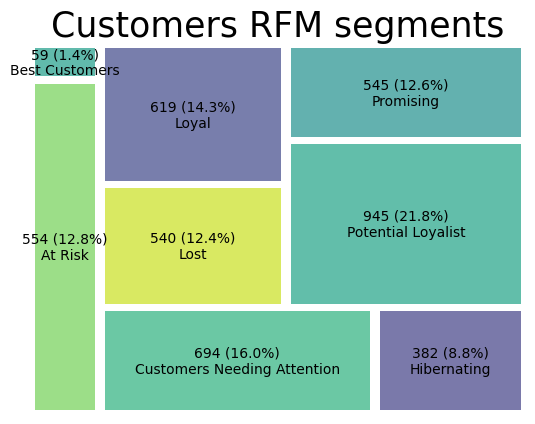

In [62]:
#Visualizing customers RFM segments
total_customers = total_customers_in_segments['CustomerID'].sum()

labels = total_customers_in_segments['CustomerID'].astype(str) + ' ('
labels += (total_customers_in_segments['CustomerID'] / total_customers * 100).round(1).astype(str)
labels += '%)' + '\n' + total_customers_in_segments.index

squarify.plot(sizes = total_customers_in_segments['CustomerID'],
              label = labels,
              pad = 0.1,
              text_kwargs = {'color':'black','fontsize':10},
              alpha = 0.7)

plt.title("Customers RFM segments", fontsize=25)
plt.axis('off')

plt.show()

K-Means

In [63]:
# Importing required libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import datetime

Text(0.5, 1.0, 'Distribution of Recency')

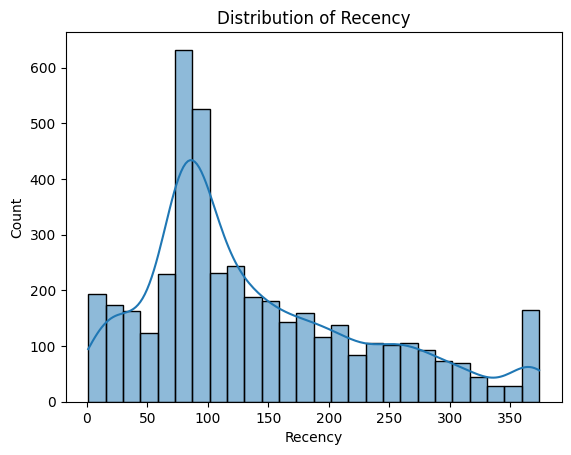

In [65]:
#Checking the distribution of Recency
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.histplot(data=customers, x='Recency', kde=True)
ax.set_title('Distribution of Recency')

<ipython-input-67-7a066959c93f>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(customers['Frequency'])


Text(0, 0.5, 'Count')

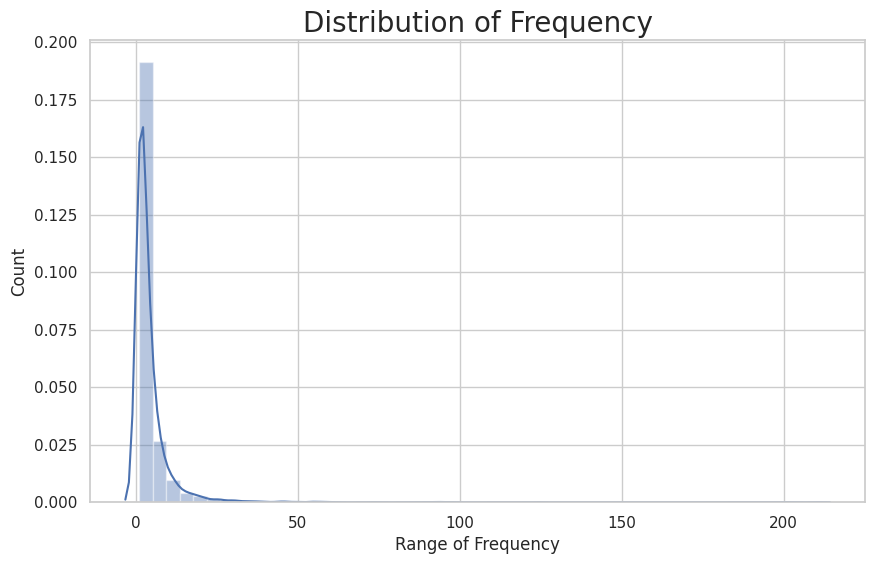

In [67]:
#Checking the distribution of Frequency
plt.figure(figsize=(10, 6))

sns.set(style = 'whitegrid')
sns.distplot(customers['Frequency'])

plt.title('Distribution of Frequency', fontsize = 20)
plt.xlabel('Range of Frequency')
plt.ylabel('Count')

<ipython-input-66-2ac7b333db26>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(customers['Monetary'])


Text(0, 0.5, 'Count')

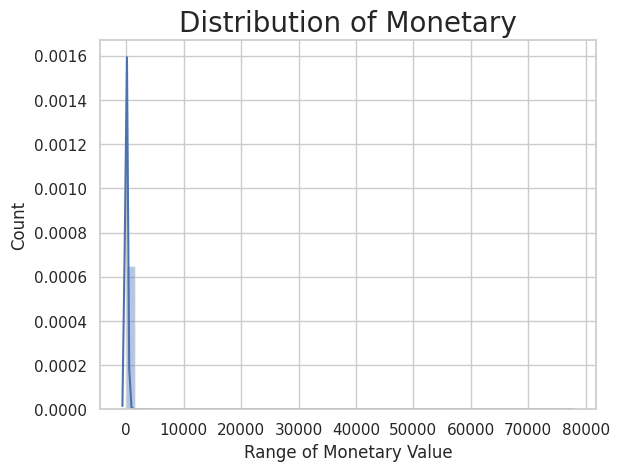

In [66]:
#Checking the distribution of Monetary value
plt.figure()

sns.set(style = 'whitegrid')
sns.distplot(customers['Monetary'])

plt.title('Distribution of Monetary', fontsize = 20)
plt.xlabel('Range of Monetary Value')
plt.ylabel('Count')

In [68]:
#Standardizing the values of Recency, Frequency and Monetary
from scipy import stats

customers_fix = pd.DataFrame()

customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["Monetary"] = stats.boxcox(customers['Monetary'])[0]

customers_fix

,Recency,Frequency,Monetary
0,28.713826,0.000000,8.850715
1,18.098647,1.340217,2.437449
2,13.679114,1.057169,4.490799
3,6.224905,0.000000,2.551078
4,28.054610,0.000000,3.005640
...,...,...,...
4333,26.540863,0.000000,2.952415
4334,21.417102,0.000000,1.560512
4335,17.882993,0.603271,2.406506
4336,15.469868,1.655631,1.767114


<ipython-input-71-f59560ee9bff>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(customers_fix['Recency'])
<ipython-input-71-f59560ee9bff>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(customers_fix['Frequency'])
<ipython-input-71-f59560ee9bff>:12: UserWarning: 

`distplot` is a deprecated fu

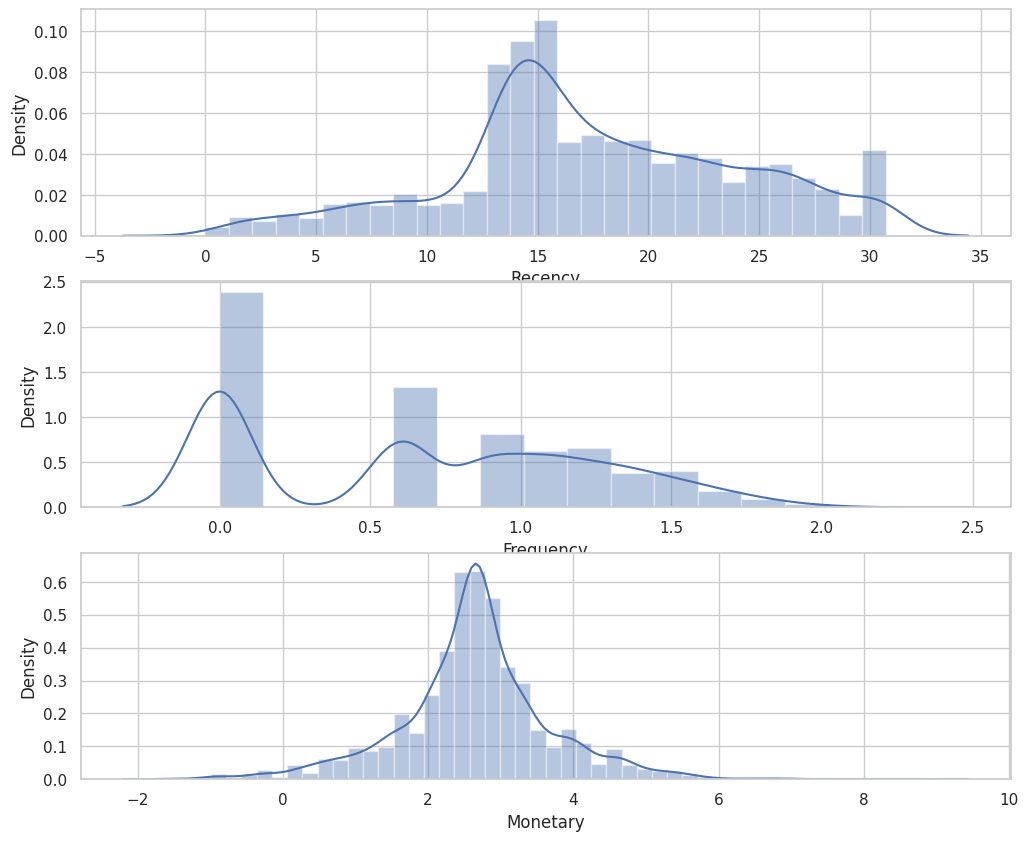

In [71]:
# Plotting RFM distributions after standardization
plt.figure(figsize=(12,10))

# Plotting distribution of Recency,Frequency and Monetary
plt.subplot(3, 1, 1);
sns.distplot(customers_fix['Recency'])

plt.subplot(3, 1, 2);
sns.distplot(customers_fix['Frequency'])

plt.subplot(3, 1, 3);
sns.distplot(customers_fix['Monetary'])

plt.show()

In [70]:
#Normalizing the RFM distributions
from sklearn.preprocessing import StandardScaler

# Initialize the Object
scaler = StandardScaler()

# Fit and Transform The Data
scaler.fit(customers_fix)

customers_normalized = scaler.transform(customers_fix)

# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[ 0. -0.  0.]
[1. 1. 1.]


In [79]:
customers_normalized

array([[ 1.69084255, -1.18407317,  5.96344211],
       [ 0.08868986,  1.16166377, -0.19402666],
       [-0.57835187,  0.6662536 ,  1.77742433],
       ...,
       [ 0.05614117, -0.12818901, -0.22373564],
       [-0.30807274,  1.71372201, -0.83762463],
       [ 0.77314299,  0.36370067, -0.4159648 ]])

In [80]:
# Converting the normalized array back into a DataFrame
normalized_df = pd.DataFrame(customers_normalized, columns=customers_fix.columns)

# Printing the normalized DataFrame
normalized_df

,Recency,Frequency,Monetary
0,1.690843,-1.184073,5.963442
1,0.088690,1.161664,-0.194027
2,-0.578352,0.666254,1.777424
3,-1.703418,-1.184073,-0.084930
4,1.591347,-1.184073,0.351502
...,...,...,...
4333,1.362876,-1.184073,0.300400
4334,0.589545,-1.184073,-1.035987
4335,0.056141,-0.128189,-0.223736
4336,-0.308073,1.713722,-0.837625


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

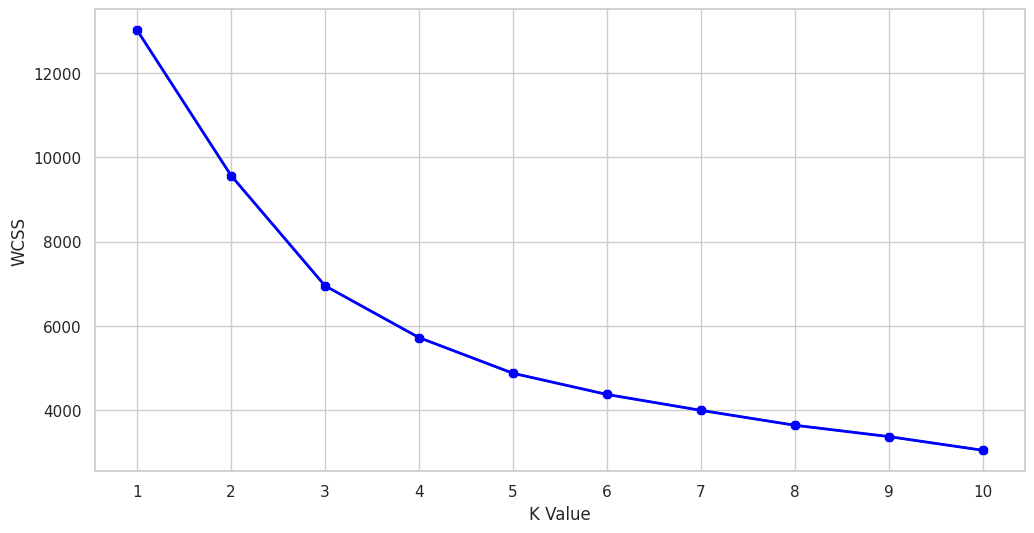

In [83]:
#Determining the optimal number of clusters for K-Means
wcss=[]
for i in range(1,11):
    km=KMeans(n_clusters=i)
    km.fit(normalized_df)
    wcss.append(km.inertia_)

#The elbow curve
plt.figure(figsize=(12,6))
plt.plot(range(1,11),wcss)
plt.plot(range(1,11),wcss, linewidth=2, color="blue", marker ="8")

plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")

plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Recency,Frequency,Monetary
Cluster,,,
0,1343,1343,1343
1,1940,1940,1940
2,1055,1055,1055


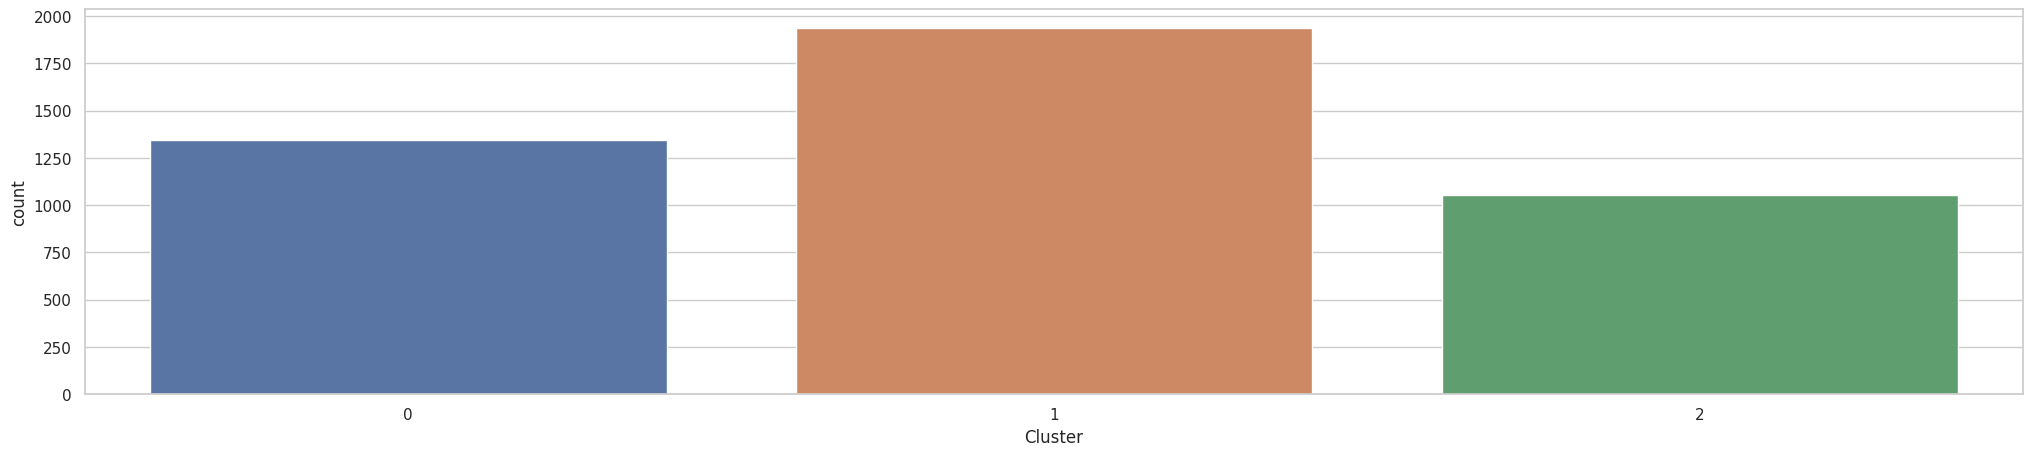

In [85]:
#Visualizing customer segments/ clusters
model = KMeans(n_clusters=3, random_state=42)
model.fit(normalized_df)
model.labels_.shape
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(2)
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="Cluster", data=customers)
customers.groupby(['Cluster']).count()

In [86]:
#Statistical distribution of the clusters
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(2)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0        248.98      1.54    94.25  1343
1        113.40      7.66    48.15  1940
2         48.80      1.44    37.21  1055

In [87]:
#Details of customers and their assigned clusters
customers

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,326,1,77183.60,0
12347.0,130,7,13.20,1
12348.0,76,4,150.00,1
12349.0,19,1,15.00,2
12350.0,311,1,25.20,0
...,...,...,...,...
18280.0,278,1,23.70,0
18281.0,181,1,5.04,0
18282.0,127,2,12.75,1


<Axes: xlabel='Monetary', ylabel='Value'>

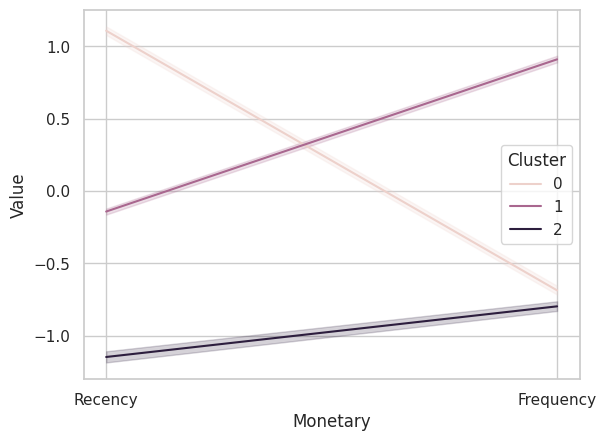

In [88]:
# Visualizing customers purchasing behaviour using snake plot
df_normalized = pd.DataFrame(normalized_df, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Monetary',
                      value_name='Value')
df_nor_melt.head()
# Visualize it
sns.lineplot(x = 'Monetary', y= 'Value', hue='Cluster', data=df_nor_melt)